<a href="https://colab.research.google.com/github/Yquetzal/ECML_PKDD_2019/blob/master/simple_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Demo of the contribution submitted at LEG workshop at ECML-PKDD 2019
This notebook allows to easily test the method introduced in the article:

`Detecting Stable Communities in Link Streams at Multiple Temporal Scales`

Authors: `Souâad Boudebza, Rémy Cazabet, Omar Nouali, Faiçal Azouaou`

### `tnetwork` library installation
The code is built on a custom library, that must be first installed using `pip`.
If you're running this code online, you probably need to execute the command in the next cell.
The documentation of this library can be found at: http://tnetwork.readthedocs.io/

In [1]:
!pip install --upgrade git+https://github.com/Yquetzal/tnetwork.git

  Cloning https://github.com/Yquetzal/tnetwork.git to /tmp/pip-req-build-f_xptghm
  Running command git clone -q https://github.com/Yquetzal/tnetwork.git /tmp/pip-req-build-f_xptghm
  Created wheel for tnetwork: filename=tnetwork-0.1-cp36-none-any.whl size=42464790 sha256=769857b7cdf87a10ac45f472101c1628c416aedbc624b17abebefb98e00122fa
  Stored in directory: /tmp/pip-ephem-wheel-cache-efi65xea/wheels/37/e6/30/4a9dea27eda470206092f8a68fd6ed5887aff43855545d906b
Successfully built tnetwork
  Found existing installation: tnetwork 0.1
    Uninstalling tnetwork-0.1:
      Successfully uninstalled tnetwork-0.1


### We can now import a set of useful libraries

In [0]:
import tnetwork as tn
import networkx as nx
import numpy as np
from bokeh.io import show, output_notebook, output_file, reset_output
from bokeh.layouts import row
from tnetwork.DCD.analytics.NMIs import NMI

We finally import the methods introduced in the article. Note that their code is integrated in the tnetwork library, but also availale as stand-alones on the same git repository as this file

In [0]:
# Our proposed method: Multiple Temporal Scale Stable Community Detection method
from tnetwork.DCD import MSSCD  
#Generator
from tnetwork.DCD.multi_temporal_scale import generate_multi_temporal_scale

## Generate a random graph with multiple temporal scale communities


In [0]:
T=1000
N= 50
SC=5
#return the generated dynamic graph and the discovered communities
generated_graph,original_coms = generate_multi_temporal_scale(nb_steps=T,nb_nodes=N,nb_com = SC)

## Plot the communities to discover
Each horizontal position corresponds to a node, color lines represent communities

* /!\ In the google colab notebook, one cannot open plots in new windows, so we use `output_notebook` and not `output_file`, to display the plots inline. This might slow down the notebook.

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:2327: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


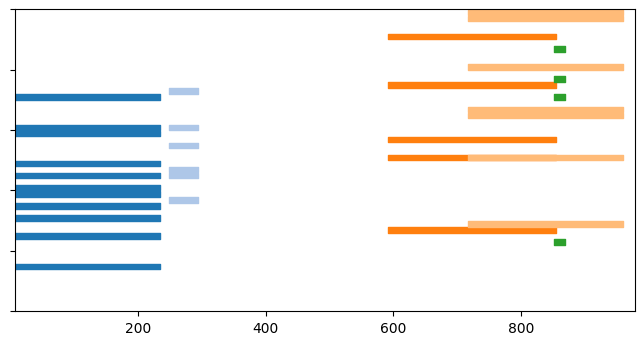

In [9]:

#define the order in which to display nodes
node_order=[str(x) for x in range(N)]
#convert the communities from a format as sequence of snapshots to a format as interval graphs. Each snapshot has a duration of 1.
communities_GT = original_coms.to_DynCommunitiesIG(sn_duration=1)
tn.plot_longitudinal(tn.DynGraphIG(),communities_GT,nodes=node_order,height=400)


## Detect stable communities using the proposed algorithm

In [10]:
#we re-state default parameters:
theta_gamma = 1 #minimum temporal scale to consider
theta_q = 0.7 #minimum quality
theta_s = 0.3 #maximum similarity to be considered different
theta_p = 3 #nb consecutive steps to be considered persistant

#persistant_coms is a list of quadruplets (nodes,period,granularity,total_quality_score)
persistant_coms = MSSCD(generated_graph,t_persistance=theta_p,t_quality=theta_q,t_similarity=theta_s)

------- granularity (gamma):  333  |  # good seeds:  1 # persistent communities found (total):  0
------- granularity (gamma):  166  |  # good seeds:  1 # persistent communities found (total):  0
------- granularity (gamma):  83  |  # good seeds:  9 # persistent communities found (total):  1
------- granularity (gamma):  41  |  # good seeds:  19 # persistent communities found (total):  2
------- granularity (gamma):  20  |  # good seeds:  35 # persistent communities found (total):  4
------- granularity (gamma):  10  |  # good seeds:  43 # persistent communities found (total):  4
------- granularity (gamma):  5  |  # good seeds:  41 # persistent communities found (total):  5
------- granularity (gamma):  2  |  # good seeds:  28 # persistent communities found (total):  5


### Plot communities found, to compare them visually
We first convert found stable communities in the appropriate dynamic community format. We use a function allowing to filter communities, that we will use also later for real communities

In [0]:
def convert_stable_communities(persistant_coms,nb_coms=None,duration_min=0,duration_max=10000000):
    visu_blocks = tn.DynCommunitiesIG()
    if nb_coms==None:
        nb_coms = len(persistant_coms)
    for nodes,period,current_granularity,score in persistant_coms[:nb_coms]:
        if period.duration()>duration_min and period.duration()<duration_max:
            #we give a unique name to each community, since colors are attributed according to community names
            name = str(period.start()).zfill(5)+","+str(nodes)+","+str(current_granularity)
            visu_blocks.add_affiliation(nodes,name,period)
    return visu_blocks

We can now plot found communities, using the same function as previously

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:2327: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


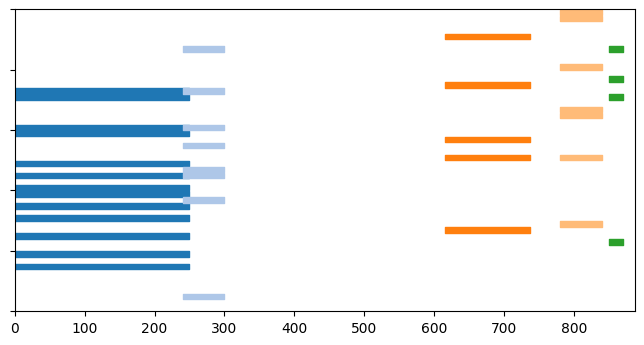

In [12]:
found_stable_communities = convert_stable_communities(persistant_coms)
tn.plot_longitudinal(tn.DynGraphIG(),found_stable_communities,nodes=node_order,height=400)


## Compute NMI at each step
We compute the NMI between the plnated communities and: i) our communities ii) communities found by another dynamic community detection algorithm (`Tracking the evolution of communities in dynamic social networks`, `Greene et al. 2010`)

In [0]:
#detect communities according to the other solution. We first aggregate the graph at the desired granularity

#aggregate the graph at the desired granularity
granularity = 13
aggregated = generated_graph.aggregate_sliding_window(granularity)

#compute communities
baseline_communities = tn.DCD.iterative_match(aggregated).to_DynCommunitiesIG(sn_duration=granularity)

In [0]:
NMIs_found = []
NMI_baseline = []
for t in range(T):
    g = generated_graph.snapshots(t)
    #get the community structure at that step
    GT_com_t = list(communities_GT.communities(t).values())
    
    #we compute NMI only when there are communities 
    #(actually favorizing the baseline, that find communities even when there aren't)
    if len(GT_com_t)>0: 
        found_com_t = list(found_stable_communities.communities(t).values())
        baseline_com_t = list(baseline_communities.communities(t).values())

        #compute NMIs
        nodes_at_t = g.nodes
        NMIs_found.append( NMI(GT_com_t,found_com_t,allNodes=nodes_at_t))
        NMI_baseline.append(NMI(GT_com_t,baseline_com_t,allNodes=nodes_at_t))

### Compute NMIs

In [15]:
print("NMI for cumulated: ",np.average(NMI_baseline))
print("NMI for proposed solution: ",np.average(NMIs_found))

NMI for cumulated:  0.25394287121533343
NMI for proposed solution:  0.5910295550689371


# Real Network Analysis (SocioPatterns)

### Loading the dataset
The studied dataset is included into the tnetwork library

In [0]:
primary_school = tn.DynGraphSN.graph_socioPatterns_Primary_School()

In [0]:
classes = tn.utils.community_utils.read_socioPatterns_Primary_School_com()

### Cleaning
We start by removing nodes not belonging to chosen classes

In [0]:
node_activity = {k:len(p) for k,p in primary_school.node_presence().items()}
to_remove={n for n,v in node_activity.items() if classes[n] not in {"1B","2B","3B","5B"}}
results = primary_school.apply_nx_function(nx.Graph.remove_nodes_from,nodes=to_remove)

We also defined an ordering of nodes, based on classes

In [0]:
ordered_nodes = sorted([(n,cl) for n,cl in classes.items()],key=lambda x:x[1])
ordered_nodes = [x[0] for x in ordered_nodes if not x[0] in to_remove]


We can now compute stable communities. We let the default parameters, but for the granularity limit, since 20s is 
the rate at which data are collected for this dataset. Note that in the dataset, dates of interaction is represented as timestamps,
therefore in term of number of seconds since origin.

In [20]:
persistant_coms_school = MSSCD(primary_school,t_granularity=20)

------- granularity (gamma):  38966  |  # good seeds:  0 # persistent communities found (total):  0
------- granularity (gamma):  19483  |  # good seeds:  13 # persistent communities found (total):  0
------- granularity (gamma):  9741  |  # good seeds:  29 # persistent communities found (total):  1
------- granularity (gamma):  4870  |  # good seeds:  54 # persistent communities found (total):  3
------- granularity (gamma):  2435  |  # good seeds:  96 # persistent communities found (total):  6
------- granularity (gamma):  1217  |  # good seeds:  180 # persistent communities found (total):  8
------- granularity (gamma):  608  |  # good seeds:  325 # persistent communities found (total):  19
------- granularity (gamma):  304  |  # good seeds:  569 # persistent communities found (total):  31
------- granularity (gamma):  152  |  # good seeds:  932 # persistent communities found (total):  50
------- granularity (gamma):  76  |  # good seeds:  1419 # persistent communities found (total)

# Plotting the found communities
### We start by plotting communities of duration more than 2 hours
Note that unlike in the article, here, we do not filter on a single day. One can filter using the `slice` function of class `tn.DynGraphIG`. Alternatively, interactive tools allow to zoom in the figure

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:2327: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


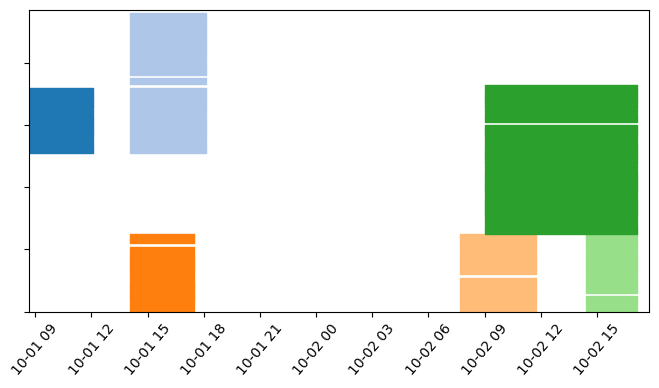

In [21]:
com_to_plot = convert_stable_communities(persistant_coms_school,duration_min=60*60*2)
tn.plot_longitudinal(tn.DynGraphIG(),com_to_plot,height=400,to_datetime=True,nodes=ordered_nodes)


### Then communities of less than half an hour

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:2327: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


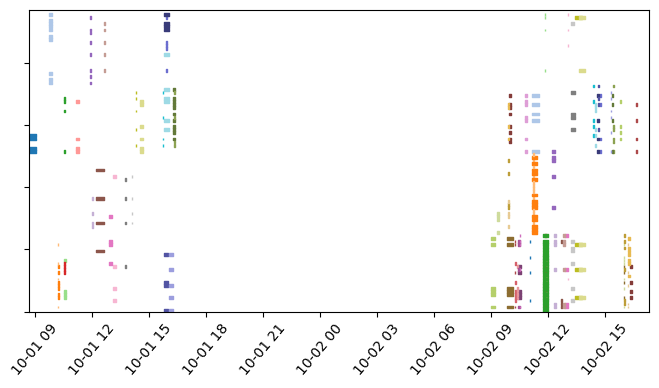

In [22]:
com_to_plot = convert_stable_communities(persistant_coms_school,duration_max=60*30)
#com_to_plot = com_to_plot.slice(1254386420,1254410770)
tn.plot_longitudinal(tn.DynGraphIG(),com_to_plot,height=400,to_datetime=True,nodes=ordered_nodes)

### Finally, remaining communities

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:2327: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


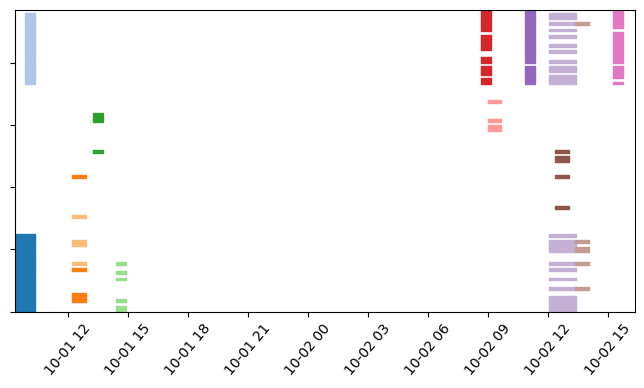

In [23]:
com_to_plot = convert_stable_communities(persistant_coms_school,duration_min=60*30,duration_max=60*60*2)
#com_to_plot = com_to_plot.slice(1254386420,1254410770)
tn.plot_longitudinal(tn.DynGraphIG(),com_to_plot,height=400,to_datetime=True,nodes=ordered_nodes)